In [1]:
# Dependencies
import os
import random
import numpy as np

import torch as th
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
# Seeding
seed = 42
random.seed(seed)
th.manual_seed( seed)
np.random.seed( seed)

In [3]:
# Loading the data
joint_probs = th.Tensor( np.load( os.path.join( "", './distribution.npy')))
# Flattening the joint prob to 1D. Each pair of x_1, x_2 is materialized by a single z,
# which is affected with the respective joint probability distribution
joint_probs = joint_probs.view((200*200))
# Creating the z Categorical distribution
z_dist = th.distributions.categorical.Categorical( probs=joint_probs)
z_samples = z_dist.sample( [int( 1e5)])
full_data = []
# Sampling z and creating fulldata with pairs
for z in z_samples:
    full_data.append( (z // 200, z % 200))

# Data set subdivision train/test
full_data = np.array( full_data)
train_ds = full_data[:int(.8*len( full_data))]
test_ds = full_data[int(.8*len( full_data)):]

In [4]:
# Some hyparams
lr = .005
seed = 42
minibatch_size = 200
n_minibatches = len( train_ds) // minibatch_size

In [5]:
# Dataloader to ease the pain
trainset = th.utils.data.DataLoader( train_ds, batch_size=minibatch_size, shuffle=True)
testset = th.utils.data.DataLoader( test_ds, batch_size=len(test_ds), shuffle=False)
# Presample the test_data for later use. Only do it once.
for test_data in testset:
    test_batch = test_data

In [6]:
# DEBUG What is the data ? Our lord and savior Alan Turing !
# plt.hist2d( test_ds[:,0], test_ds[:,1], bins=(200,200), cmap='gist_gray')
# plt.hist2d( train_ds[:,0], train_ds[:,1], bins=(200,200), cmap='gist_gray')
# The fewer the samples, the lower the image's "resolution"
# plt.hist2d( full_data[:,0], full_data[:,1], bins=(200,200), cmap='gist_gray')
# plt.show()

# print( train_ds.shape)
# print( test_ds.shape)

In [7]:
# The following shall be used to plot a histogram of the data distribution of x_1
x1_counters = { i: 0 for i in range(200)}
for x in full_data[:,0]:
    x1_counters[x]+= 1
x1_histogram = np.array( [ x1_counters[i] / len( full_data[:,0]) for i in range( 200)])

In [8]:
# Helpers
def get_loss_1( thetas, x1s):
    return th.index_select( - F.log_softmax( thetas, 0), 0, x1s).mean()

def get_loss_2( model, x1s, x2s):
    logprobs = model.get_log_softmax( F.one_hot(x1s, 200).float())
    
    loss = F.nll_loss( logprobs, x2s).mean()

    return loss

In [9]:
# Model definition
## Parameters for P_\theta(x1)
thetas_1 = th.zeros( [200], requires_grad=True)

## MLP used to model P_\theta(x2|x1)
class SimpleMLP( th.nn.Module):
    def __init__(self, input_dim = 200, hidden_sizes=[300], output_dim=200):
        super().__init__()
        self.layers = th.nn.ModuleList()

        current_dim = input_dim
        for hsize in hidden_sizes:
            self.layers.append(th.nn.Linear( current_dim, hsize))
            current_dim = hsize

        self.layers.append(th.nn.Linear( current_dim, output_dim))

    def forward( self, x):
        output = x
        for layer in self.layers[:-1]:
            output = F.relu(layer( output))

        return self.layers[-1]( output)

    def get_softmax( self, x):
        return F.softmax( self( x), 1)

    def get_log_softmax( self, x):
        return F.log_softmax( self( x), 1)

p_theta_2 = SimpleMLP()

n_epochs = 100

# P theta 2 stuff
optim1 = optim.Adam([thetas_1], lr=lr)
optim2 = optim.Adam(p_theta_2.parameters(), lr=lr)

Epoch 0 (Last MB Loss)
	 Train Loss 1: 5.2795 , Test Loss 1: 5.2852
	 Train Loss 2: 5.2698 , Test Loss 2: 5.2639

Epoch 1 (Last MB Loss)
	 Train Loss 1: 5.3035 , Test Loss 1: 5.2851
	 Train Loss 2: 5.2697 , Test Loss 2: 5.2793

Epoch 2 (Last MB Loss)
	 Train Loss 1: 5.2708 , Test Loss 1: 5.2853
	 Train Loss 2: 5.1430 , Test Loss 2: 5.3073

Epoch 3 (Last MB Loss)
	 Train Loss 1: 5.2506 , Test Loss 1: 5.2850
	 Train Loss 2: 5.2183 , Test Loss 2: 5.3280

Epoch 4 (Last MB Loss)
	 Train Loss 1: 5.2859 , Test Loss 1: 5.2853
	 Train Loss 2: 5.1610 , Test Loss 2: 5.3520

Epoch 5 (Last MB Loss)
	 Train Loss 1: 5.2718 , Test Loss 1: 5.2855
	 Train Loss 2: 5.1298 , Test Loss 2: 5.3668



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


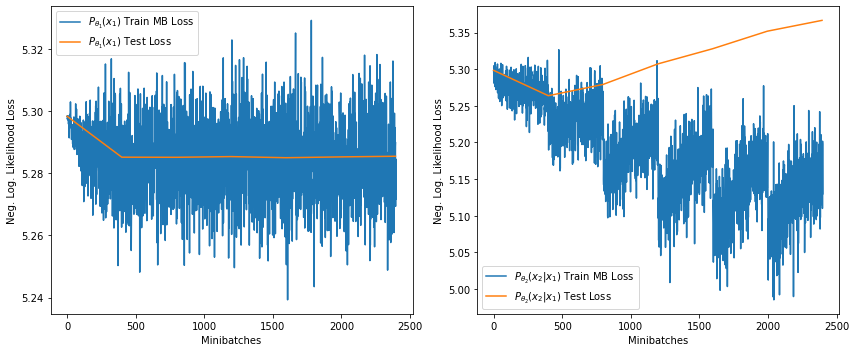

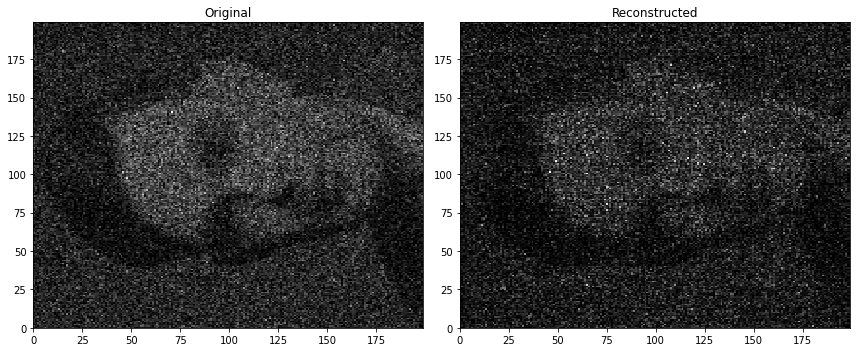

Epoch 6 (Last MB Loss)
	 Train Loss 1: 5.2755 , Test Loss 1: 5.2852
	 Train Loss 2: 5.1235 , Test Loss 2: 5.3797

Epoch 7 (Last MB Loss)
	 Train Loss 1: 5.2952 , Test Loss 1: 5.2856
	 Train Loss 2: 5.0660 , Test Loss 2: 5.3880

Epoch 8 (Last MB Loss)
	 Train Loss 1: 5.2871 , Test Loss 1: 5.2851
	 Train Loss 2: 5.0736 , Test Loss 2: 5.4008

Epoch 9 (Last MB Loss)
	 Train Loss 1: 5.2861 , Test Loss 1: 5.2853
	 Train Loss 2: 5.1068 , Test Loss 2: 5.4081

Epoch 10 (Last MB Loss)
	 Train Loss 1: 5.2570 , Test Loss 1: 5.2855
	 Train Loss 2: 5.1541 , Test Loss 2: 5.4109



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


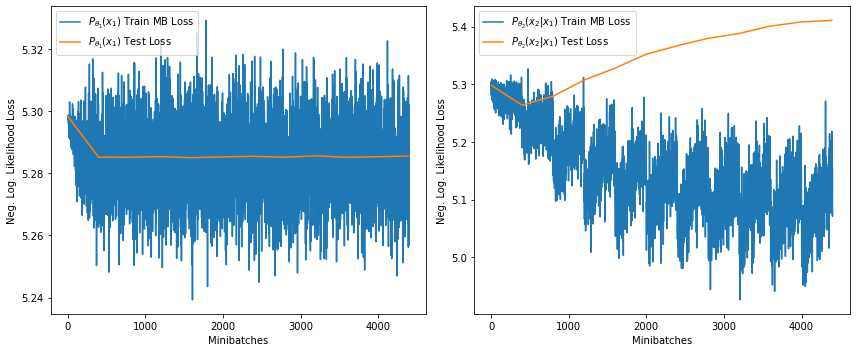

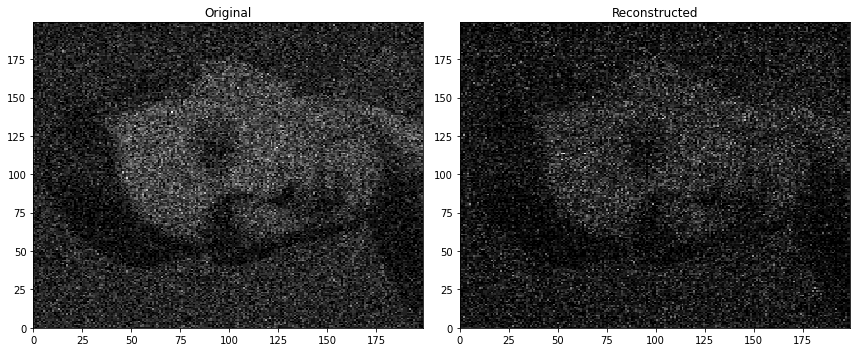

Epoch 11 (Last MB Loss)
	 Train Loss 1: 5.3002 , Test Loss 1: 5.2856
	 Train Loss 2: 5.1064 , Test Loss 2: 5.4180

Epoch 12 (Last MB Loss)
	 Train Loss 1: 5.2684 , Test Loss 1: 5.2856
	 Train Loss 2: 5.0271 , Test Loss 2: 5.4230

Epoch 13 (Last MB Loss)
	 Train Loss 1: 5.2866 , Test Loss 1: 5.2856
	 Train Loss 2: 5.1048 , Test Loss 2: 5.4296

Epoch 14 (Last MB Loss)
	 Train Loss 1: 5.2572 , Test Loss 1: 5.2855
	 Train Loss 2: 5.1741 , Test Loss 2: 5.4318

Epoch 15 (Last MB Loss)
	 Train Loss 1: 5.3148 , Test Loss 1: 5.2855
	 Train Loss 2: 5.1658 , Test Loss 2: 5.4348



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


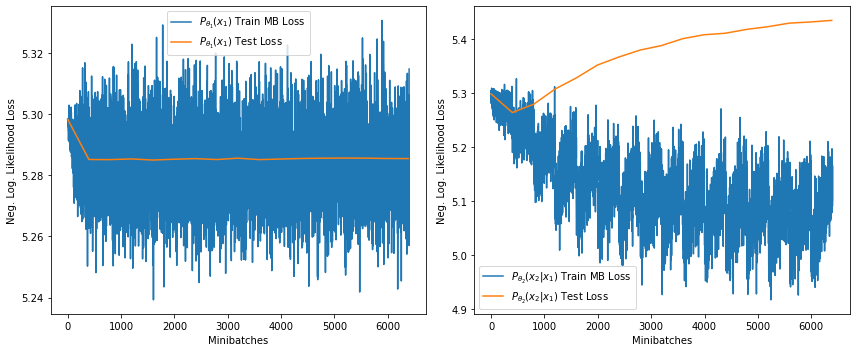

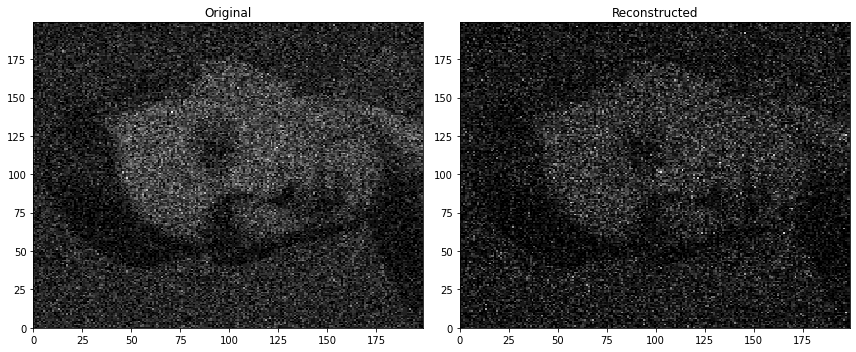

Epoch 16 (Last MB Loss)
	 Train Loss 1: 5.2796 , Test Loss 1: 5.2852
	 Train Loss 2: 5.0760 , Test Loss 2: 5.4417

Epoch 17 (Last MB Loss)
	 Train Loss 1: 5.2813 , Test Loss 1: 5.2852
	 Train Loss 2: 5.1132 , Test Loss 2: 5.4482

Epoch 18 (Last MB Loss)
	 Train Loss 1: 5.2772 , Test Loss 1: 5.2853
	 Train Loss 2: 5.1644 , Test Loss 2: 5.4495

Epoch 19 (Last MB Loss)
	 Train Loss 1: 5.2844 , Test Loss 1: 5.2852
	 Train Loss 2: 5.1106 , Test Loss 2: 5.4494

Epoch 20 (Last MB Loss)
	 Train Loss 1: 5.2935 , Test Loss 1: 5.2853
	 Train Loss 2: 5.1587 , Test Loss 2: 5.4566



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


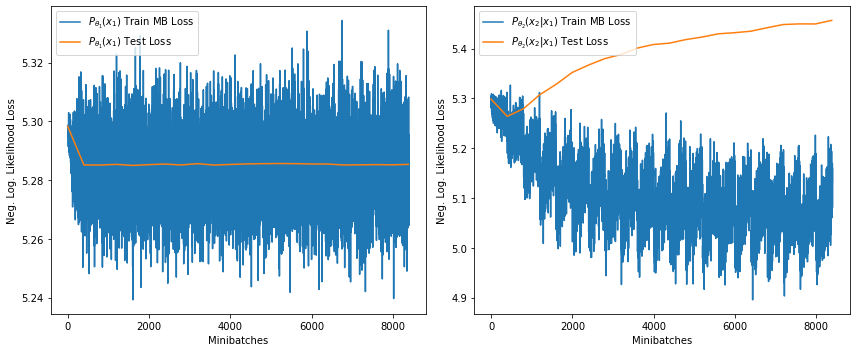

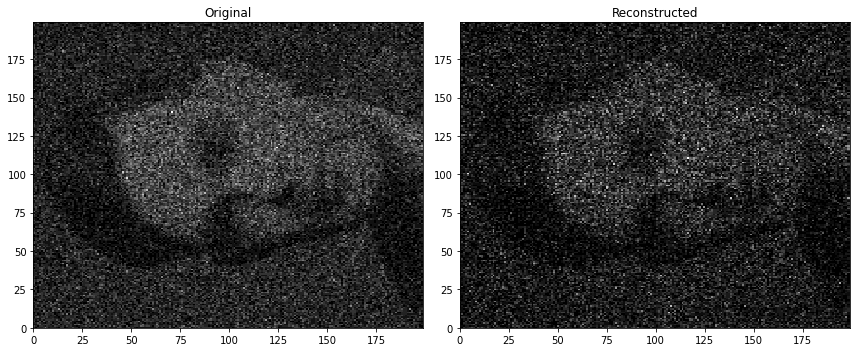

Epoch 21 (Last MB Loss)
	 Train Loss 1: 5.2757 , Test Loss 1: 5.2852
	 Train Loss 2: 5.1205 , Test Loss 2: 5.4606

Epoch 22 (Last MB Loss)
	 Train Loss 1: 5.2768 , Test Loss 1: 5.2852
	 Train Loss 2: 5.1199 , Test Loss 2: 5.4618

Epoch 23 (Last MB Loss)
	 Train Loss 1: 5.3060 , Test Loss 1: 5.2855
	 Train Loss 2: 5.1027 , Test Loss 2: 5.4711

Epoch 24 (Last MB Loss)
	 Train Loss 1: 5.3025 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0917 , Test Loss 2: 5.4713

Epoch 25 (Last MB Loss)
	 Train Loss 1: 5.2841 , Test Loss 1: 5.2855
	 Train Loss 2: 5.1023 , Test Loss 2: 5.4730



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


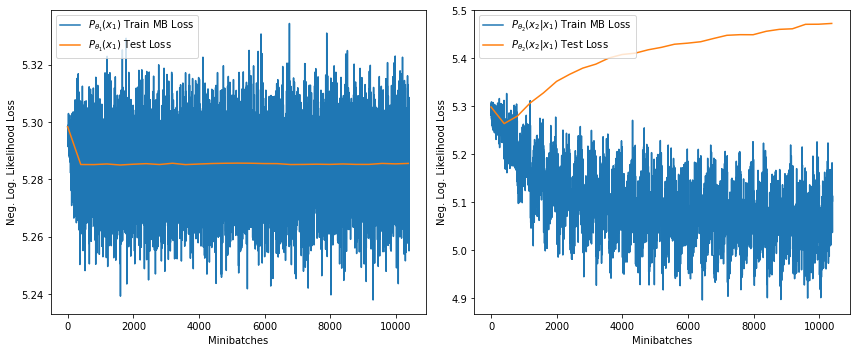

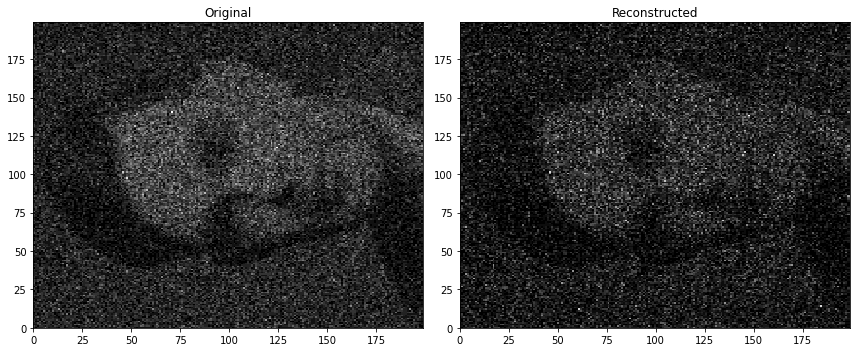

Epoch 26 (Last MB Loss)
	 Train Loss 1: 5.2813 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0873 , Test Loss 2: 5.4787

Epoch 27 (Last MB Loss)
	 Train Loss 1: 5.2664 , Test Loss 1: 5.2853
	 Train Loss 2: 5.2062 , Test Loss 2: 5.4783

Epoch 28 (Last MB Loss)
	 Train Loss 1: 5.3072 , Test Loss 1: 5.2852
	 Train Loss 2: 5.0917 , Test Loss 2: 5.4810

Epoch 29 (Last MB Loss)
	 Train Loss 1: 5.3046 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0678 , Test Loss 2: 5.4848

Epoch 30 (Last MB Loss)
	 Train Loss 1: 5.3110 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0812 , Test Loss 2: 5.4919



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


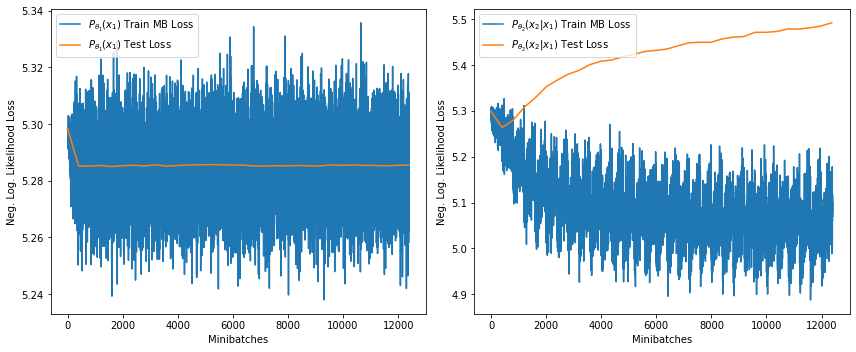

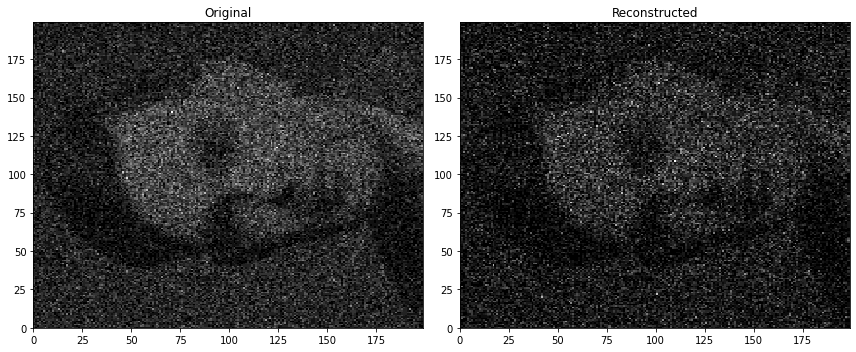

Epoch 31 (Last MB Loss)
	 Train Loss 1: 5.2683 , Test Loss 1: 5.2853
	 Train Loss 2: 5.0724 , Test Loss 2: 5.4940

Epoch 32 (Last MB Loss)
	 Train Loss 1: 5.2839 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0933 , Test Loss 2: 5.4922

Epoch 33 (Last MB Loss)
	 Train Loss 1: 5.2608 , Test Loss 1: 5.2856
	 Train Loss 2: 5.1481 , Test Loss 2: 5.4912

Epoch 34 (Last MB Loss)
	 Train Loss 1: 5.2743 , Test Loss 1: 5.2855
	 Train Loss 2: 5.1283 , Test Loss 2: 5.4953

Epoch 35 (Last MB Loss)
	 Train Loss 1: 5.3061 , Test Loss 1: 5.2856
	 Train Loss 2: 5.1621 , Test Loss 2: 5.5025



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


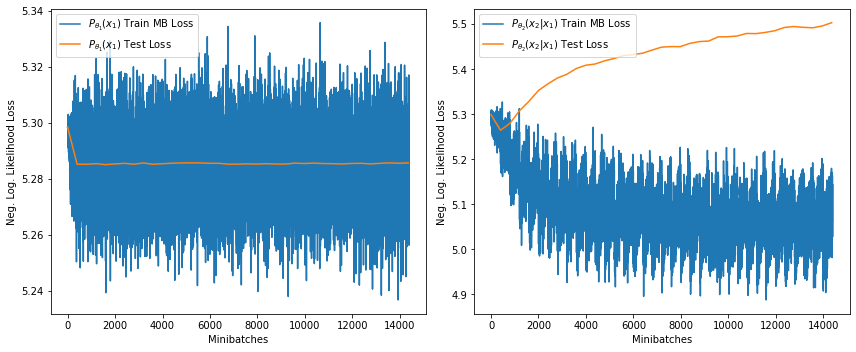

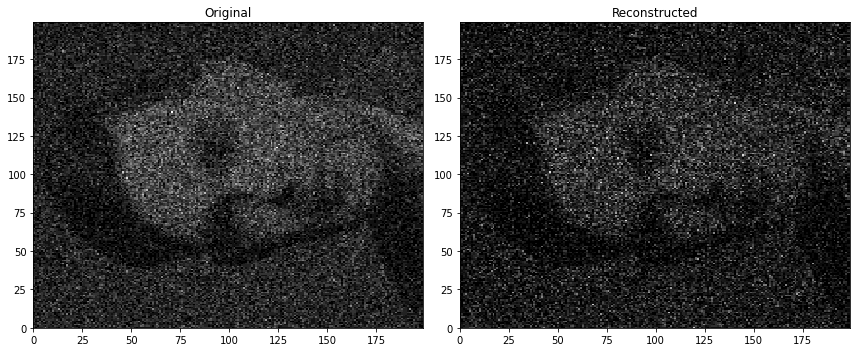

Epoch 36 (Last MB Loss)
	 Train Loss 1: 5.2802 , Test Loss 1: 5.2857
	 Train Loss 2: 5.0550 , Test Loss 2: 5.5034

Epoch 37 (Last MB Loss)
	 Train Loss 1: 5.2892 , Test Loss 1: 5.2857
	 Train Loss 2: 5.0497 , Test Loss 2: 5.5045

Epoch 38 (Last MB Loss)
	 Train Loss 1: 5.2641 , Test Loss 1: 5.2856
	 Train Loss 2: 5.0146 , Test Loss 2: 5.5080

Epoch 39 (Last MB Loss)
	 Train Loss 1: 5.2975 , Test Loss 1: 5.2856
	 Train Loss 2: 5.0404 , Test Loss 2: 5.5176

Epoch 40 (Last MB Loss)
	 Train Loss 1: 5.2840 , Test Loss 1: 5.2852
	 Train Loss 2: 5.1193 , Test Loss 2: 5.5147



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


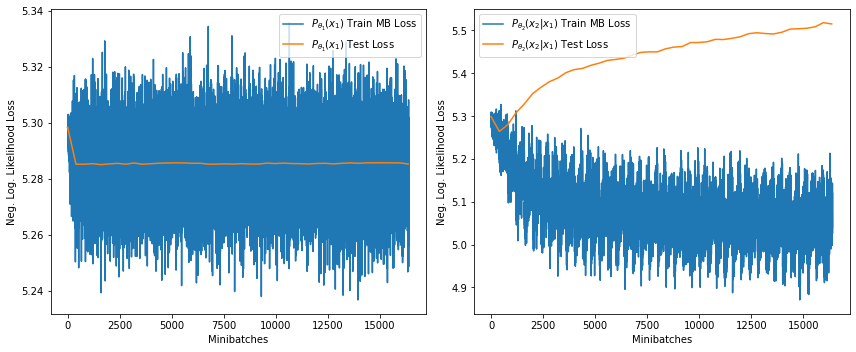

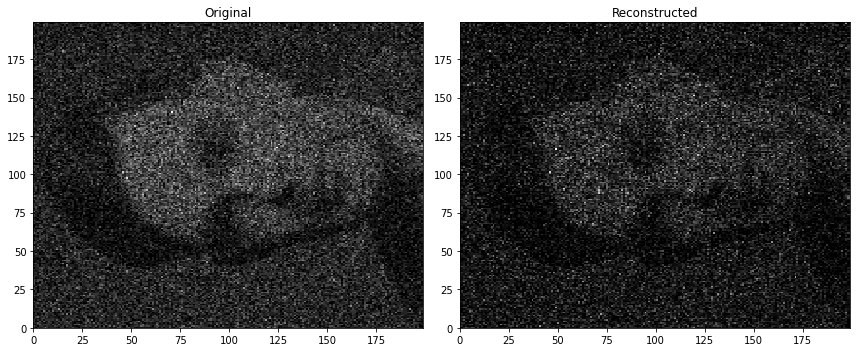

Epoch 41 (Last MB Loss)
	 Train Loss 1: 5.3021 , Test Loss 1: 5.2851
	 Train Loss 2: 5.0097 , Test Loss 2: 5.5207

Epoch 42 (Last MB Loss)
	 Train Loss 1: 5.3047 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0459 , Test Loss 2: 5.5192

Epoch 43 (Last MB Loss)
	 Train Loss 1: 5.2904 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0987 , Test Loss 2: 5.5223

Epoch 44 (Last MB Loss)
	 Train Loss 1: 5.2897 , Test Loss 1: 5.2852
	 Train Loss 2: 5.0980 , Test Loss 2: 5.5211

Epoch 45 (Last MB Loss)
	 Train Loss 1: 5.2851 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0352 , Test Loss 2: 5.5268



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


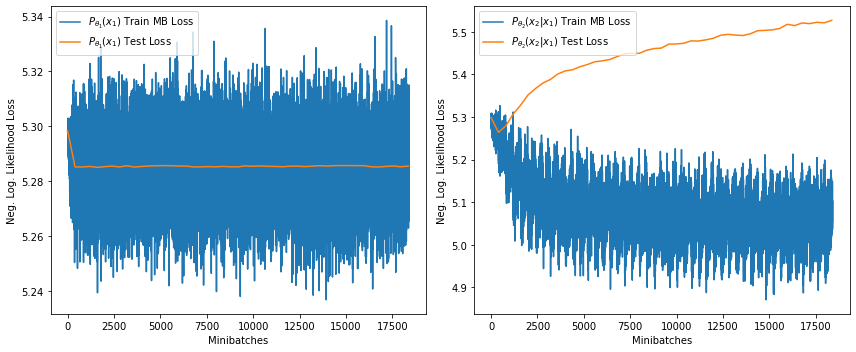

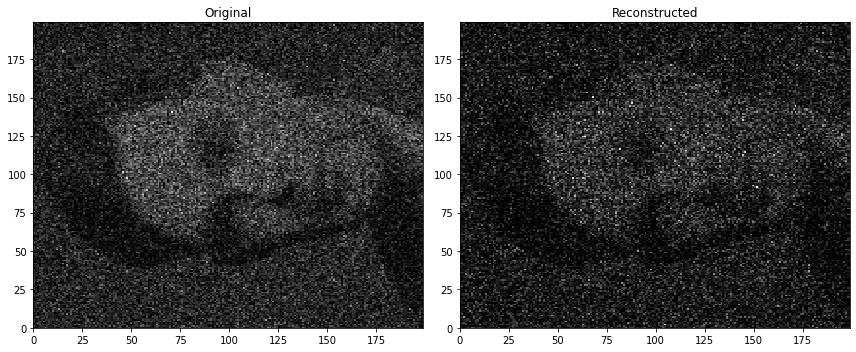

Epoch 46 (Last MB Loss)
	 Train Loss 1: 5.2791 , Test Loss 1: 5.2852
	 Train Loss 2: 5.1258 , Test Loss 2: 5.5342

Epoch 47 (Last MB Loss)
	 Train Loss 1: 5.2719 , Test Loss 1: 5.2850
	 Train Loss 2: 5.0732 , Test Loss 2: 5.5275

Epoch 48 (Last MB Loss)
	 Train Loss 1: 5.3021 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0180 , Test Loss 2: 5.5309

Epoch 49 (Last MB Loss)
	 Train Loss 1: 5.2734 , Test Loss 1: 5.2852
	 Train Loss 2: 5.0648 , Test Loss 2: 5.5322

Epoch 50 (Last MB Loss)
	 Train Loss 1: 5.2708 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0652 , Test Loss 2: 5.5345



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


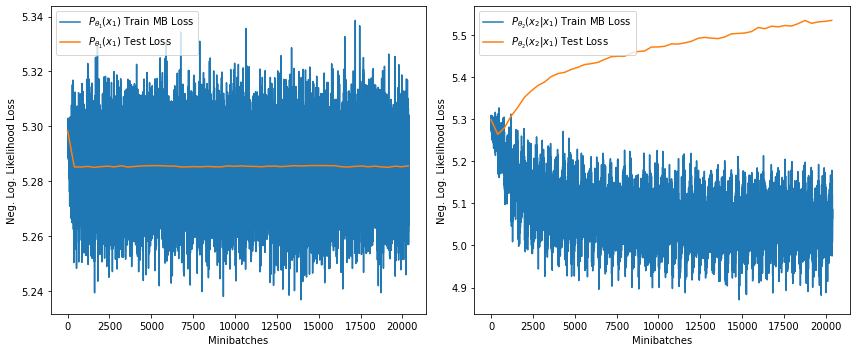

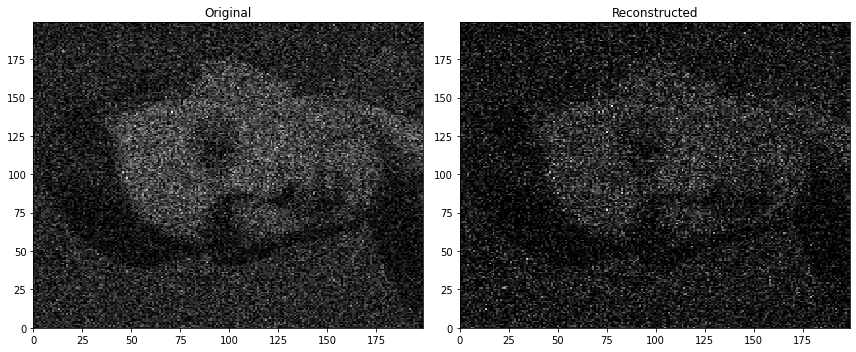

Epoch 51 (Last MB Loss)
	 Train Loss 1: 5.3110 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0277 , Test Loss 2: 5.5451

Epoch 52 (Last MB Loss)
	 Train Loss 1: 5.2800 , Test Loss 1: 5.2853
	 Train Loss 2: 5.1222 , Test Loss 2: 5.5461

Epoch 53 (Last MB Loss)
	 Train Loss 1: 5.2976 , Test Loss 1: 5.2852
	 Train Loss 2: 5.0447 , Test Loss 2: 5.5500

Epoch 54 (Last MB Loss)
	 Train Loss 1: 5.3060 , Test Loss 1: 5.2854
	 Train Loss 2: 4.9940 , Test Loss 2: 5.5433

Epoch 55 (Last MB Loss)
	 Train Loss 1: 5.2865 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0589 , Test Loss 2: 5.5504



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


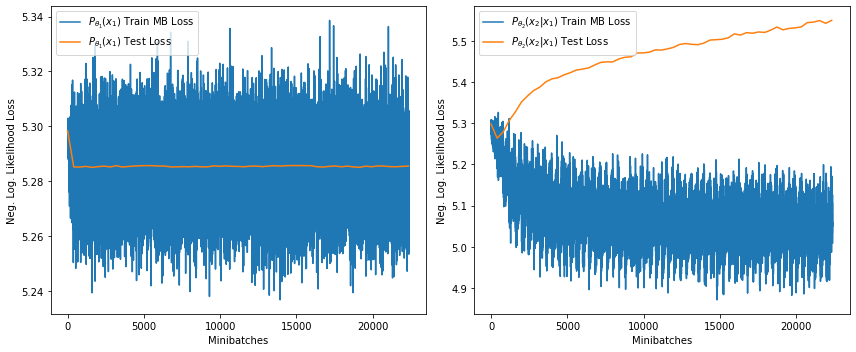

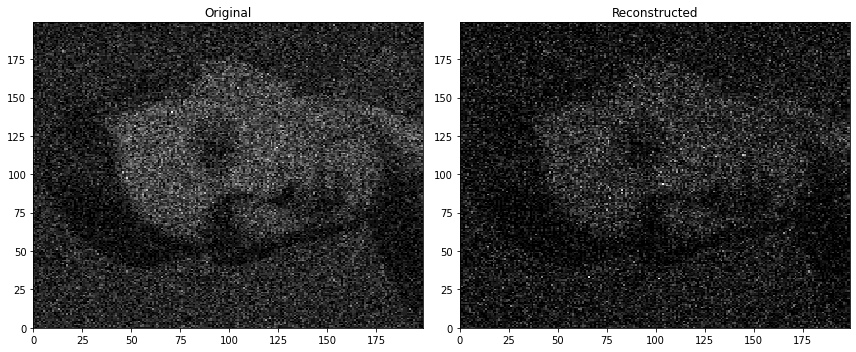

Epoch 56 (Last MB Loss)
	 Train Loss 1: 5.2968 , Test Loss 1: 5.2852
	 Train Loss 2: 5.1130 , Test Loss 2: 5.5487

Epoch 57 (Last MB Loss)
	 Train Loss 1: 5.2892 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0418 , Test Loss 2: 5.5557

Epoch 58 (Last MB Loss)
	 Train Loss 1: 5.2887 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0580 , Test Loss 2: 5.5568

Epoch 59 (Last MB Loss)
	 Train Loss 1: 5.2853 , Test Loss 1: 5.2852
	 Train Loss 2: 5.0624 , Test Loss 2: 5.5651

Epoch 60 (Last MB Loss)
	 Train Loss 1: 5.2874 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0718 , Test Loss 2: 5.5582



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


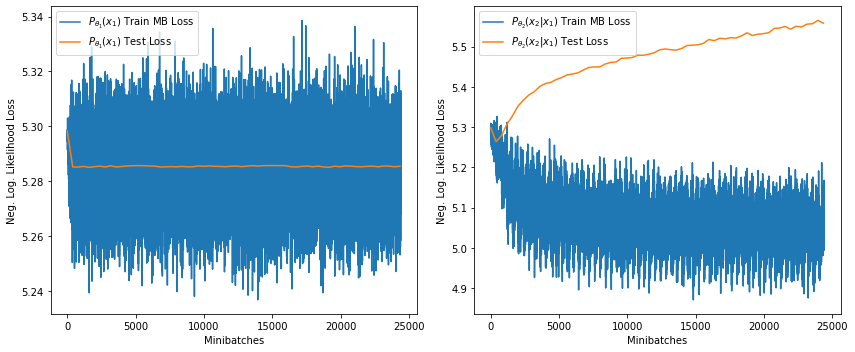

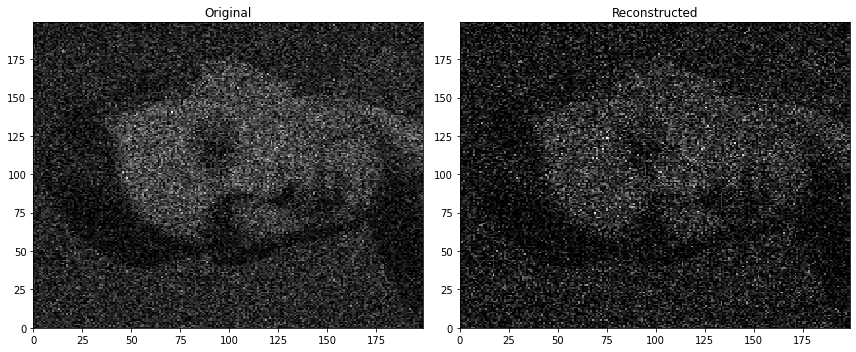

Epoch 61 (Last MB Loss)
	 Train Loss 1: 5.2764 , Test Loss 1: 5.2853
	 Train Loss 2: 5.0186 , Test Loss 2: 5.5639

Epoch 62 (Last MB Loss)
	 Train Loss 1: 5.2657 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0778 , Test Loss 2: 5.5645

Epoch 63 (Last MB Loss)
	 Train Loss 1: 5.2935 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0703 , Test Loss 2: 5.5735

Epoch 64 (Last MB Loss)
	 Train Loss 1: 5.2954 , Test Loss 1: 5.2856
	 Train Loss 2: 5.1118 , Test Loss 2: 5.5684

Epoch 65 (Last MB Loss)
	 Train Loss 1: 5.2620 , Test Loss 1: 5.2856
	 Train Loss 2: 5.1725 , Test Loss 2: 5.5710



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


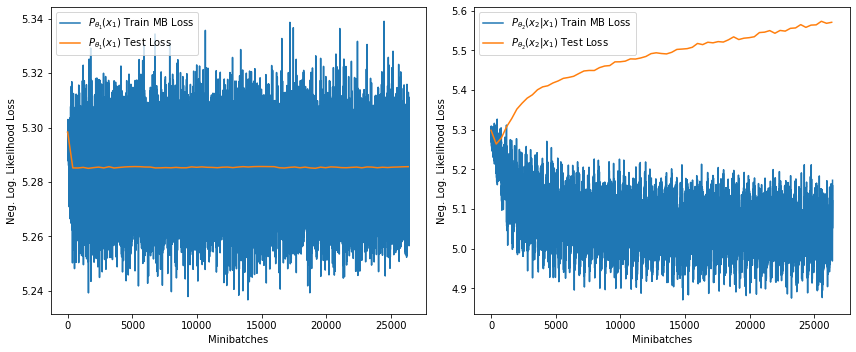

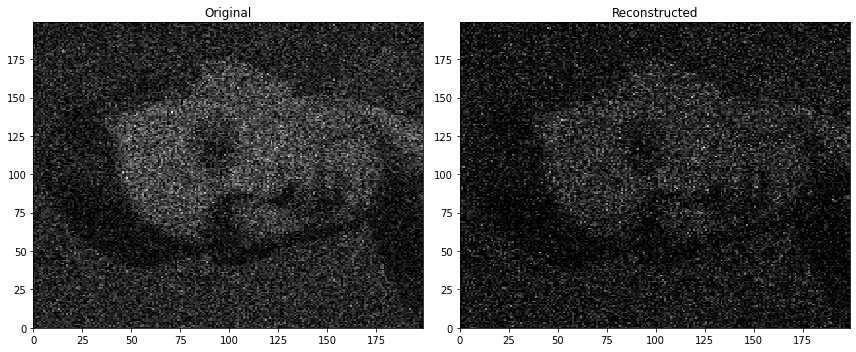

Epoch 66 (Last MB Loss)
	 Train Loss 1: 5.2751 , Test Loss 1: 5.2856
	 Train Loss 2: 5.1043 , Test Loss 2: 5.5748

Epoch 67 (Last MB Loss)
	 Train Loss 1: 5.2847 , Test Loss 1: 5.2856
	 Train Loss 2: 5.1060 , Test Loss 2: 5.5749

Epoch 68 (Last MB Loss)
	 Train Loss 1: 5.2886 , Test Loss 1: 5.2858
	 Train Loss 2: 5.0658 , Test Loss 2: 5.5755

Epoch 69 (Last MB Loss)
	 Train Loss 1: 5.2840 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0335 , Test Loss 2: 5.5807

Epoch 70 (Last MB Loss)
	 Train Loss 1: 5.2806 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0826 , Test Loss 2: 5.5811



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


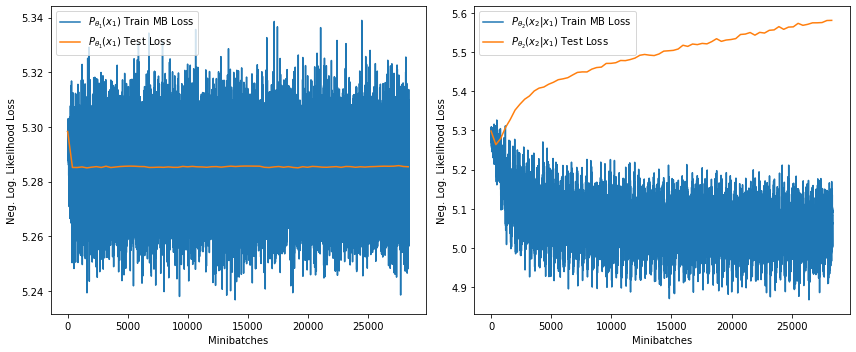

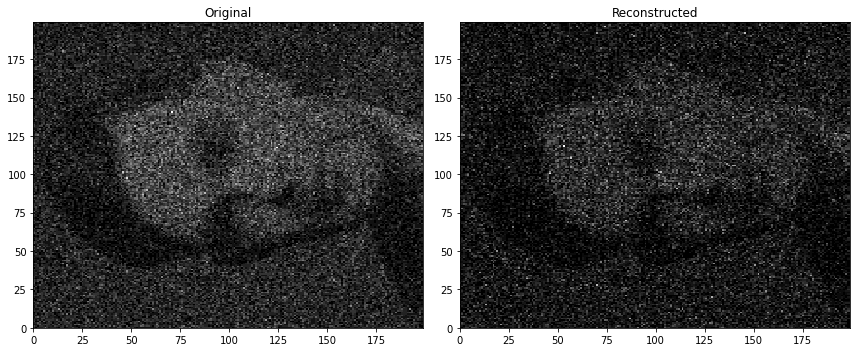

Epoch 71 (Last MB Loss)
	 Train Loss 1: 5.3018 , Test Loss 1: 5.2854
	 Train Loss 2: 5.1217 , Test Loss 2: 5.5844

Epoch 72 (Last MB Loss)
	 Train Loss 1: 5.2661 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0645 , Test Loss 2: 5.5848

Epoch 73 (Last MB Loss)
	 Train Loss 1: 5.2734 , Test Loss 1: 5.2853
	 Train Loss 2: 5.0511 , Test Loss 2: 5.5912

Epoch 74 (Last MB Loss)
	 Train Loss 1: 5.2913 , Test Loss 1: 5.2856
	 Train Loss 2: 5.0313 , Test Loss 2: 5.5840

Epoch 75 (Last MB Loss)
	 Train Loss 1: 5.2758 , Test Loss 1: 5.2856
	 Train Loss 2: 5.0385 , Test Loss 2: 5.5926



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


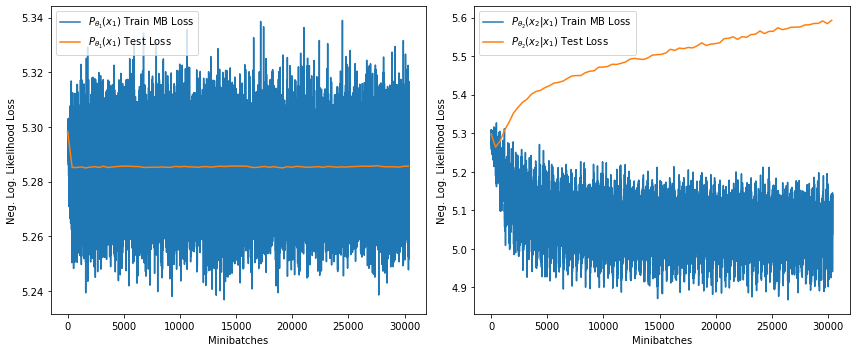

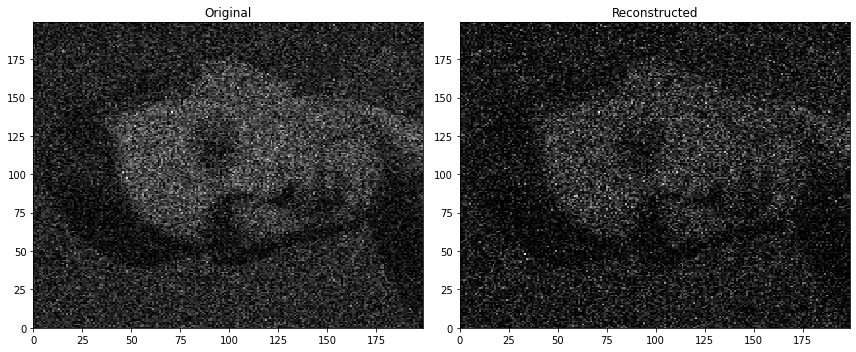

Epoch 76 (Last MB Loss)
	 Train Loss 1: 5.2938 , Test Loss 1: 5.2856
	 Train Loss 2: 5.0944 , Test Loss 2: 5.5912

Epoch 77 (Last MB Loss)
	 Train Loss 1: 5.2709 , Test Loss 1: 5.2854
	 Train Loss 2: 5.1071 , Test Loss 2: 5.6009

Epoch 78 (Last MB Loss)
	 Train Loss 1: 5.2895 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0515 , Test Loss 2: 5.5946

Epoch 79 (Last MB Loss)
	 Train Loss 1: 5.2724 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0562 , Test Loss 2: 5.6031

Epoch 80 (Last MB Loss)
	 Train Loss 1: 5.3186 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0133 , Test Loss 2: 5.6038



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


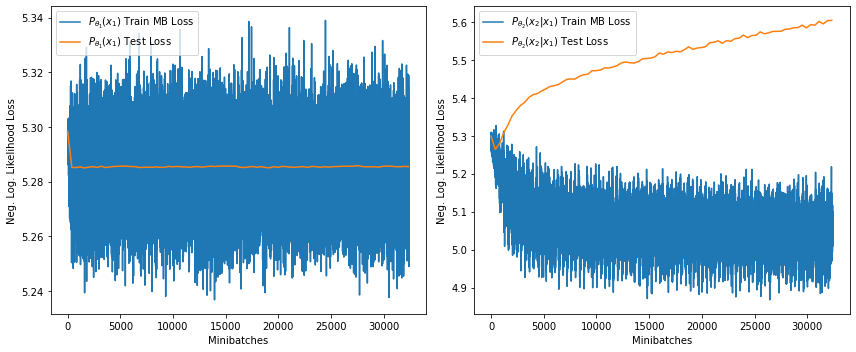

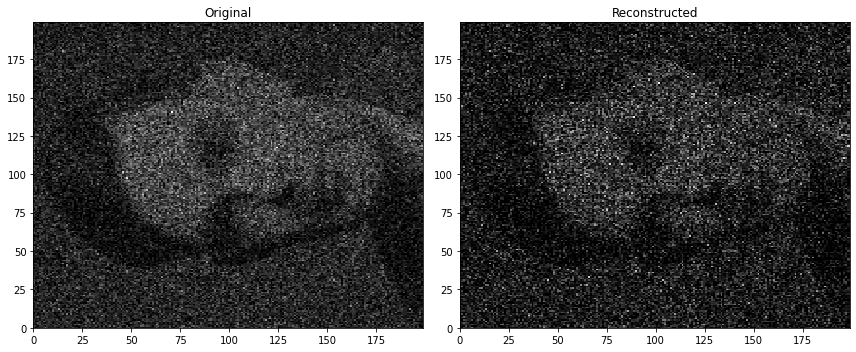

Epoch 81 (Last MB Loss)
	 Train Loss 1: 5.2914 , Test Loss 1: 5.2855
	 Train Loss 2: 5.1057 , Test Loss 2: 5.6050

Epoch 82 (Last MB Loss)
	 Train Loss 1: 5.2780 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0910 , Test Loss 2: 5.6059

Epoch 83 (Last MB Loss)
	 Train Loss 1: 5.2989 , Test Loss 1: 5.2854
	 Train Loss 2: 5.1039 , Test Loss 2: 5.6098

Epoch 84 (Last MB Loss)
	 Train Loss 1: 5.2864 , Test Loss 1: 5.2850
	 Train Loss 2: 5.0652 , Test Loss 2: 5.6118

Epoch 85 (Last MB Loss)
	 Train Loss 1: 5.2884 , Test Loss 1: 5.2853
	 Train Loss 2: 5.0378 , Test Loss 2: 5.6133



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


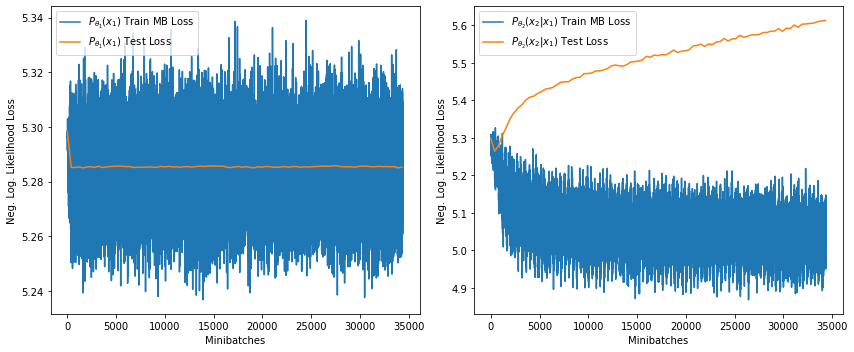

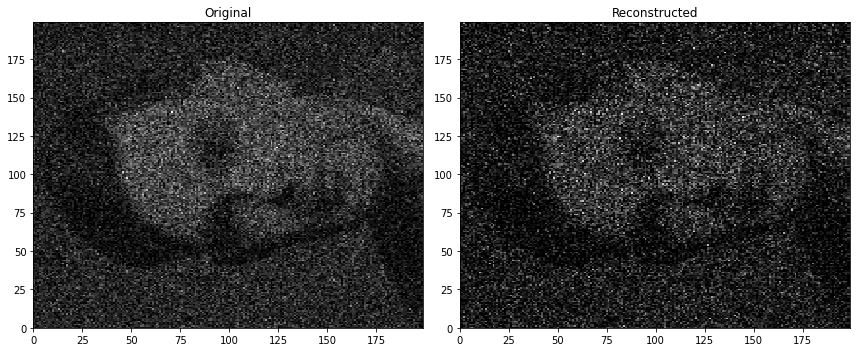

Epoch 86 (Last MB Loss)
	 Train Loss 1: 5.2917 , Test Loss 1: 5.2852
	 Train Loss 2: 5.0816 , Test Loss 2: 5.6153

Epoch 87 (Last MB Loss)
	 Train Loss 1: 5.2901 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0369 , Test Loss 2: 5.6135

Epoch 88 (Last MB Loss)
	 Train Loss 1: 5.2875 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0914 , Test Loss 2: 5.6199

Epoch 89 (Last MB Loss)
	 Train Loss 1: 5.2958 , Test Loss 1: 5.2852
	 Train Loss 2: 5.0943 , Test Loss 2: 5.6200

Epoch 90 (Last MB Loss)
	 Train Loss 1: 5.2983 , Test Loss 1: 5.2855
	 Train Loss 2: 5.0683 , Test Loss 2: 5.6220



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


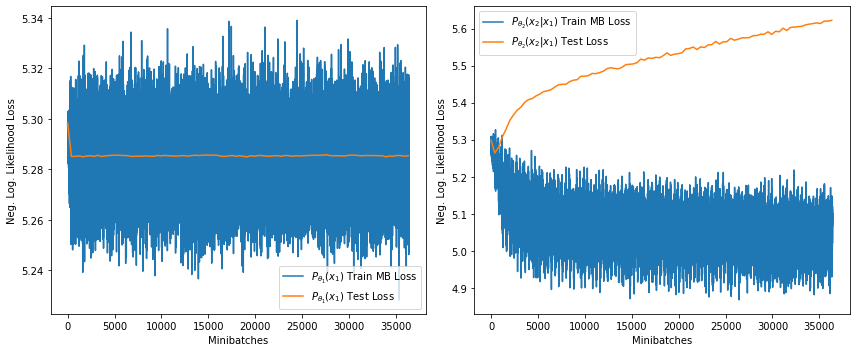

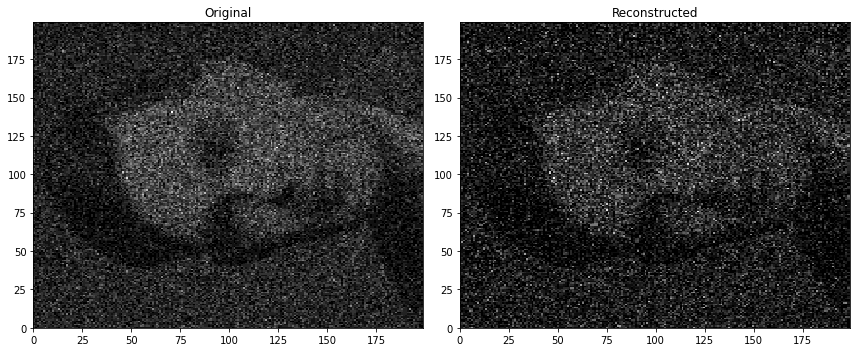

Epoch 91 (Last MB Loss)
	 Train Loss 1: 5.3134 , Test Loss 1: 5.2855
	 Train Loss 2: 5.1057 , Test Loss 2: 5.6194

Epoch 92 (Last MB Loss)
	 Train Loss 1: 5.2961 , Test Loss 1: 5.2852
	 Train Loss 2: 5.1084 , Test Loss 2: 5.6216

Epoch 93 (Last MB Loss)
	 Train Loss 1: 5.2811 , Test Loss 1: 5.2857
	 Train Loss 2: 5.0677 , Test Loss 2: 5.6294

Epoch 94 (Last MB Loss)
	 Train Loss 1: 5.2818 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0462 , Test Loss 2: 5.6246

Epoch 95 (Last MB Loss)
	 Train Loss 1: 5.2956 , Test Loss 1: 5.2857
	 Train Loss 2: 4.9716 , Test Loss 2: 5.6238



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


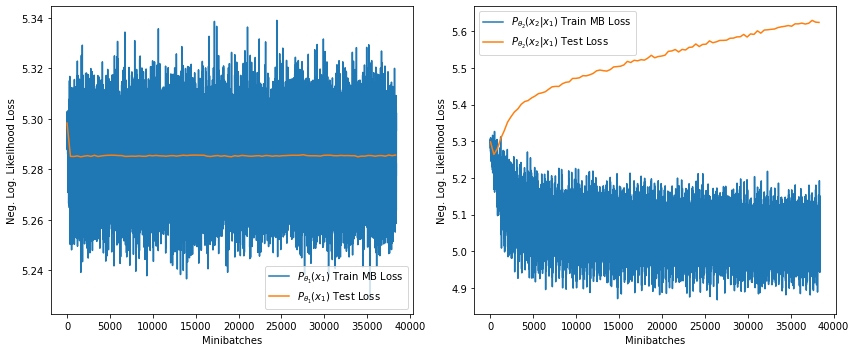

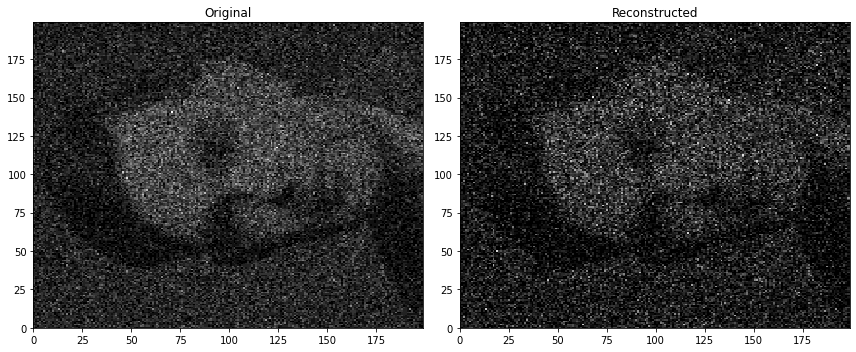

Epoch 96 (Last MB Loss)
	 Train Loss 1: 5.3039 , Test Loss 1: 5.2853
	 Train Loss 2: 5.0572 , Test Loss 2: 5.6325

Epoch 97 (Last MB Loss)
	 Train Loss 1: 5.2837 , Test Loss 1: 5.2856
	 Train Loss 2: 5.1037 , Test Loss 2: 5.6262

Epoch 98 (Last MB Loss)
	 Train Loss 1: 5.2740 , Test Loss 1: 5.2853
	 Train Loss 2: 5.0908 , Test Loss 2: 5.6381

Epoch 99 (Last MB Loss)
	 Train Loss 1: 5.2779 , Test Loss 1: 5.2854
	 Train Loss 2: 5.0524 , Test Loss 2: 5.6303



/home/d055/anaconda3/envs/cs294deepul/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


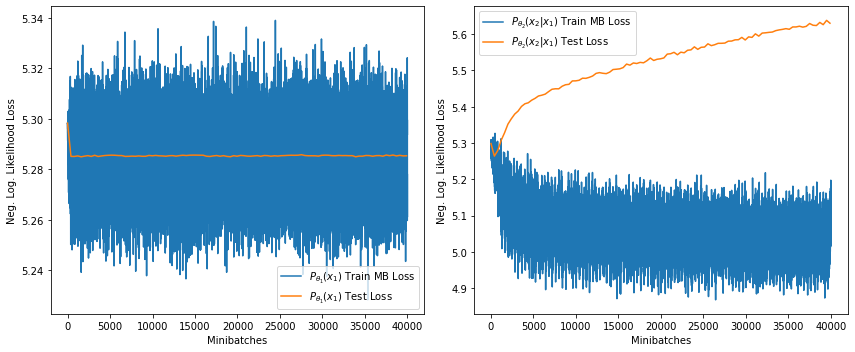

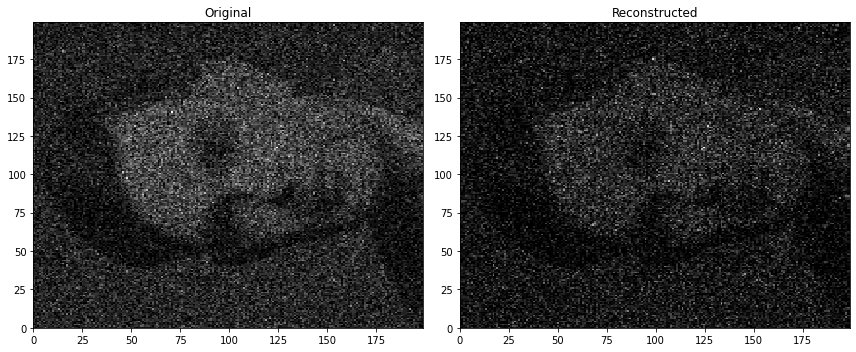

In [10]:
# Training loop
mb_train_losses = { 'loss1': [], 'loss2': []}
test_losses = { 'loss1': [], 'loss2': []}

# Separating the x1s and x2s from the (x1,x2) for the testset data
# Doing it here makes it more efficient than inside the loop ?
test_x1s = test_batch[:, 0]
test_x2s = test_batch[:, 1]

test_loss1 = get_loss_1( thetas_1, test_x1s)
test_loss2 = get_loss_2( p_theta_2, test_x1s, test_x2s)

test_losses["loss1"].append( test_loss1.item())
test_losses["loss2"].append( test_loss2.item())

# for epoch in range( n_epochs):
for epoch in range( n_epochs):
    # Iterate over minibatches
    for mb_idx, mb_train_data in enumerate(trainset):
        # Separating the x1s and x2s from the (x1,x2) minibatch data
        
        mb_x1s = mb_train_data[:, 0]
        mb_x2s = mb_train_data[:, 1]

        # Train P_theta_1
        loss1 = get_loss_1(thetas_1, mb_x1s)

        # Update the thetas_1
        optim1.zero_grad()
        loss1.backward()
        optim1.step()

        mb_train_losses["loss1"].append(loss1.item())

        # Training P_theta_2
        loss2 = get_loss_2(p_theta_2, mb_x1s, mb_x2s)
        
        # Updating the weights of P_theta_2
        p_theta_2.zero_grad()
        loss2.backward()
        optim2.step()

        mb_train_losses['loss2'].append(loss2.item())
    
    test_loss1 = get_loss_1(thetas_1, test_x1s)
    test_losses["loss1"].append(test_loss1)
        
    test_loss2 = get_loss_2(p_theta_2, test_x1s, test_x2s)
    test_losses["loss2"].append(test_loss2)
    
    print( "Epoch %d (Last MB Loss)" % (epoch))
    print( "\t Train Loss 1: %.4f , Test Loss 1: %.4f" %( loss1, test_loss1))
    print( "\t Train Loss 2: %.4f , Test Loss 2: %.4f" %( loss2, test_loss2))
    print("")

    if (epoch > 0 and epoch % 5 == 0) or epoch == (n_epochs -1):
        # Special: Checking the histogram of P_theta_1
        # with th.no_grad():
        #     thetas_1_probs = F.softmax( thetas_1, 0).numpy()
        #
        # fig, ax = plt.subplots()
        #
        # ax.set_title('Dist. Comp. after %d epochs of training (from scratch)' % epoch)
        # x = np.arange( 1,201)
        # width = 0.35
        # rects1 = ax.bar(x - width/2, thetas_1_probs, width, label='Model')
        # rects2 = ax.bar(x + width/2, x1_histogram, width, label='Empirical')
        # ax.set_ylabel('Likelihood')
        # ax.set_xlabel('Variable $x_1$\'s values')
        # ax.legend()
        #
        # fig.tight_layout()
        # fig.show()
    
        # Deliverable 1. Train and test losses so far.
        fig, axes = plt.subplots(1, 2,figsize=(12,5))

        x_mbs_train = np.arange(len(mb_train_losses["loss2"]))
        x_mbs_test = np.arange(0, len(mb_train_losses["loss2"]), mb_idx) # Test loss at the end of each epoch needs to account for gap in minibatch

        # Ploting loss of P_theta_1 model
        x_mbs_train_1 = np.arange(len(mb_train_losses["loss1"]))
        x_mbs_test_1 = np.arange(0, len(mb_train_losses["loss1"]), mb_idx) # Test loss at the end of each epoch needs to account for gap in minibatch

        axes[0].plot(x_mbs_train_1, mb_train_losses["loss1"],label="$P_{\\theta_1}(x_1)$ Train MB Loss")
        axes[0].plot(x_mbs_test_1, test_losses["loss1"],label="$P_{\\theta_1}(x_1)$ Test Loss")
        axes[0].set_xlabel("Minibatches")
        axes[0].set_ylabel("Neg. Log. Likelihood Loss")
        axes[0].legend()

        # Plotting loss of P_theta_2 model
        axes[1].plot(x_mbs_train, mb_train_losses["loss2"],label="$P_{\\theta_2}(x_2 | x_1)$ Train MB Loss")
        axes[1].plot(x_mbs_test, test_losses["loss2"],label="$P_{\\theta_2}(x_2 | x_1)$ Test Loss",)
        axes[1].set_xlabel("Minibatches")
        axes[1].set_ylabel("Neg. Log. Likelihood Loss")
        axes[1].legend()

        fig.tight_layout()
        fig.show()
        
        # Deliverable 2. but as the training progresses
        # Plotting sampled points and original on the left
        fig, axes = plt.subplots(1,2,figsize=(12,5))
        axes[0].hist2d( full_data[:,0], full_data[:,1], bins=(200,200), cmap='gist_gray')
        axes[0].set_title('Original')

        # Drawing samples
        thetas_1_probs = F.softmax( thetas_1, 0)

        x1_dist = th.distributions.categorical.Categorical(probs=thetas_1_probs)
        x1_theta_samples = x1_dist.sample( [int( 1e5)]).long()
        
        x2_given_x1_probs = p_theta_2.get_softmax( F.one_hot( x1_theta_samples, 200).float())

        x2_given_x1_samples = []
        for x2_given_x1_prob in x2_given_x1_probs:
            x2_given_x1_dist = th.distributions.categorical.Categorical( probs=x2_given_x1_prob)
            x2_given_x1_samples.append( x2_given_x1_dist.sample([1]).item())
        
        x1_theta_samples = x1_theta_samples.detach().numpy()
        
        axes[1].hist2d( x1_theta_samples, x2_given_x1_samples, bins=(200,200), cmap='gist_gray')
        axes[1].set_title('Reconstructed')
        fig.tight_layout()

        plt.show()